模型在训练cuda:0上训练


 20%|██        | 10/50 [07:50<30:54, 46.36s/it]

第10轮训练 ==> 训练损失:  0.00037 	 训练准确率:  97.19% 	  测试准确率:  95.99%


 40%|████      | 20/50 [15:35<23:07, 46.24s/it]

第20轮训练 ==> 训练损失:  0.00029 	 训练准确率:  97.95% 	  测试准确率:  96.59%


 60%|██████    | 30/50 [23:19<15:28, 46.42s/it]

第30轮训练 ==> 训练损失:  0.00025 	 训练准确率:  98.70% 	  测试准确率:  97.27%


 80%|████████  | 40/50 [31:04<07:43, 46.37s/it]

第40轮训练 ==> 训练损失:  0.00023 	 训练准确率:  98.01% 	  测试准确率:  96.69%


100%|██████████| 50/50 [38:48<00:00, 46.57s/it]

第50轮训练 ==> 训练损失:  0.00018 	 训练准确率:  99.14% 	  测试准确率:  97.13%


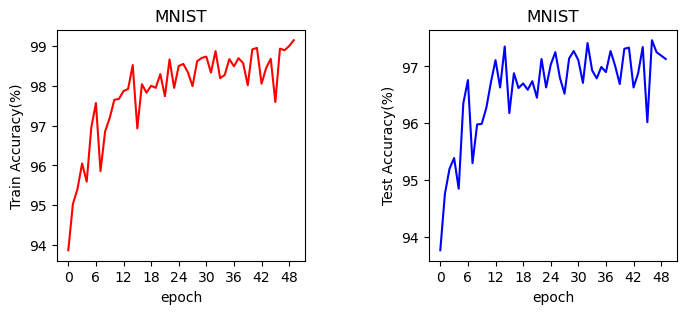

In [1]:
import random
import torch.utils
from torchvision.transforms import ToTensor, Resize, Normalize, Compose
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from matplotlib import ticker

import torch.nn as nn
import torch
import matplotlib.pyplot as plt


torch.cuda.manual_seed(43)
torch.manual_seed(43)
random.seed(43)

transform_list = []

transform_list.append(ToTensor())
transform_list.append(Resize(28)) 
transform_list.append(Normalize((0.5), (0.5)))

transform_list = Compose(transform_list)


path = "../dataset/mnist"
dataset_train = MNIST(root=path, download=True, train=True, transform=transform_list)

# We ALWAYS keep the full test set for final model evaluation
dataset_test = MNIST(root=path, download=True, train=False, transform=transform_list)

train_loader = DataLoader(dataset_train, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=256, shuffle=True)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
    
    def forward(self, x):
        return self.model(x)


def model_eval(data_iter, device):
    model.eval()
    correct_num = 0
    total_num = 0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(data_iter):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            correct_num += torch.sum(torch.argmax(output, dim=1) == labels).item()
            total_num += labels.shape[0]
    return correct_num / total_num * 100

def train(model, train_loader, test_loader, optimizer, loss, epoches, lr, device):
    train_accuracy_array = []
    test_accuracy_array = []
    for epoch in tqdm(range(epoches)):
        losses, nums = 0.0, 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            l = loss(output, y)

            losses += l.item()
            nums += y.shape[0]

            # Update net params
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        
        train_accuracy = model_eval(train_loader, device)
        test_accuracy = model_eval(test_loader, device)
        train_accuracy_array.append(train_accuracy)
        test_accuracy_array.append(test_accuracy)
        if (epoch + 1) % 10 == 0:
            print(f"第{epoch + 1}轮训练 ==> 训练损失: {losses / nums: .5f} \t 训练准确率: {train_accuracy: .2f}% \t  测试准确率: {test_accuracy: .2f}%")
    
    return train_accuracy_array, test_accuracy_array

device = "cuda:0" if torch.cuda.is_available else "cpu"
model = MLP().to(device)
epoches = 50
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr)
loss = torch.nn.CrossEntropyLoss()

print(f"模型在训练{device}上训练")

train_accuracy_array, test_accuracy_array = train(model, train_loader, test_loader, optimizer, loss, epoches, lr, device)

_, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(range(len(train_accuracy_array)), train_accuracy_array, c='r') 
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("Train Accuracy(%)")
axes[0].set_title("MNIST")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(range(len(test_accuracy_array)), test_accuracy_array, c='b')
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("Test Accuracy(%)")
axes[1].set_title("MNIST")
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.subplots_adjust(wspace=0.5)
plt.show()